In [1]:
!pip install torchviz torchsummary

    100% |████████████████████████████████| 51kB 3.8MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import torchvision
import os
from torchvision import models
from torchviz import make_dot

In [3]:
N_CLASSES = 6
IN_CHANNELS = 5

In [4]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[list(range(in_channels)), list(range(out_channels)), :, :] = filt
    return torch.from_numpy(weight).float()

In [5]:
class _PyramidPoolingModule(nn.Module):
    def __init__(self, in_dim, reduction_dim, setting):
        super(_PyramidPoolingModule, self).__init__()
        self.features = []
        for s in setting:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(s),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim, momentum=.95),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        out = torch.cat(out, 1)
        return out


class PSPNet(nn.Module):
    def __init__(self, num_classes=N_CLASSES, pretrained=True, use_aux=True):
        super(PSPNet, self).__init__()
        self.use_aux = use_aux
        resnet = models.resnet101()
        if pretrained:
            resnet.load_state_dict(torch.load('../input/resnet101/resnet101.pth'))
        resnet.conv1 = nn.Conv2d(IN_CHANNELS, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)

        self.ppm = _PyramidPoolingModule(2048, 512, (1, 2, 3, 6))
        self.final = nn.Sequential(
            nn.Conv2d(4096, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512, momentum=.95),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )

        if use_aux:
            self.aux_logits = nn.Conv2d(1024, num_classes, kernel_size=1)
            initialize_weights(self.aux_logits)

        initialize_weights(self.ppm, self.final)

    def forward(self, x):
        x_size = x.size()
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        if self.use_aux:
            aux = self.aux_logits(x)
        x = self.layer4(x)
        x = self.ppm(x)
        x = self.final(x)
        if self.use_aux:
            return F.interpolate(x, x_size[2:], mode='bilinear', align_corners=True) + F.interpolate(aux, x_size[2:], mode='bilinear', align_corners=True)
        return F.interpolate(x, x_size[2:], mode='bilinear', align_corners=True)

In [6]:
net = PSPNet()
net.cuda()

PSPNet(
  (layer0): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), 

In [7]:
from torchsummary import summary
summary(net, input_size=(5, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          15,680
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [8]:
x = Variable(torch.rand(4, 5, 256, 256))
out = PSPNet()(x)

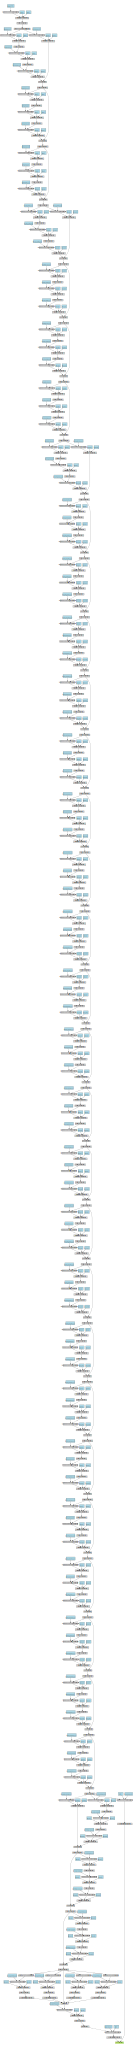

In [9]:
make_dot(out)